Running small λ simulations...
Running large λ simulations...


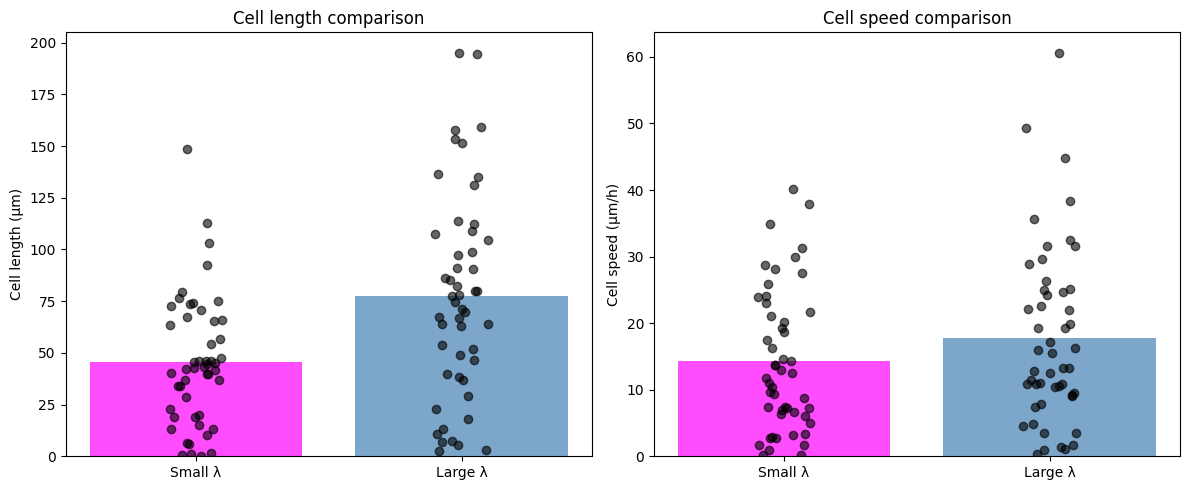

Length significance (small vs large λ): 0.0001947958893972607
Speed significance (small vs large λ): 0.1393021262578077
Plotting example trajectory for small λ...


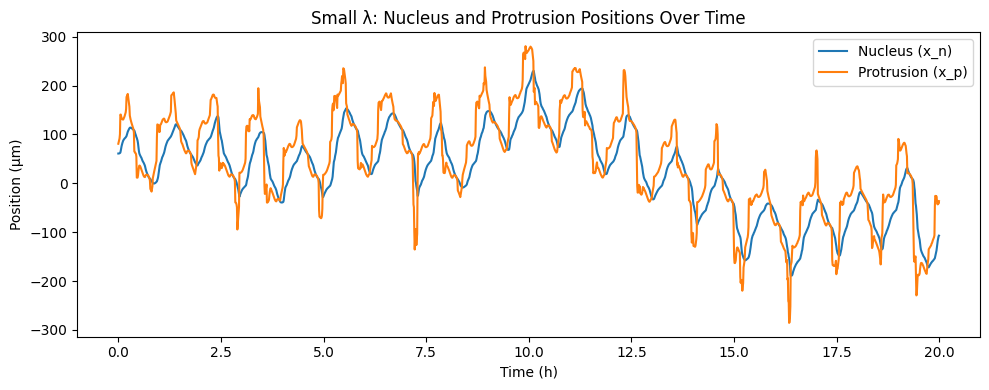

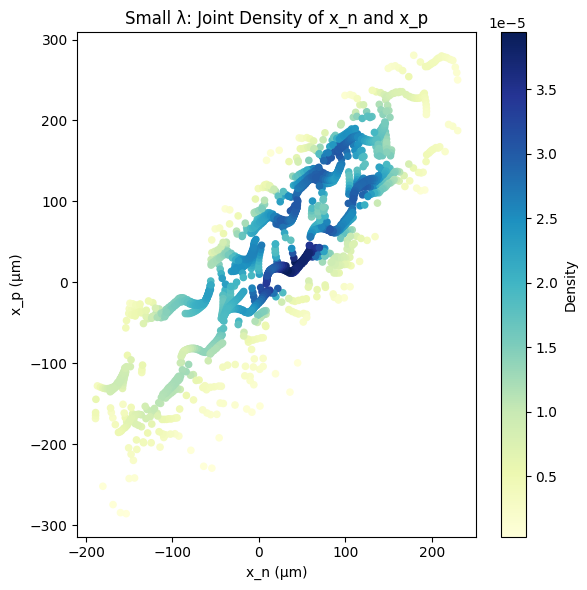

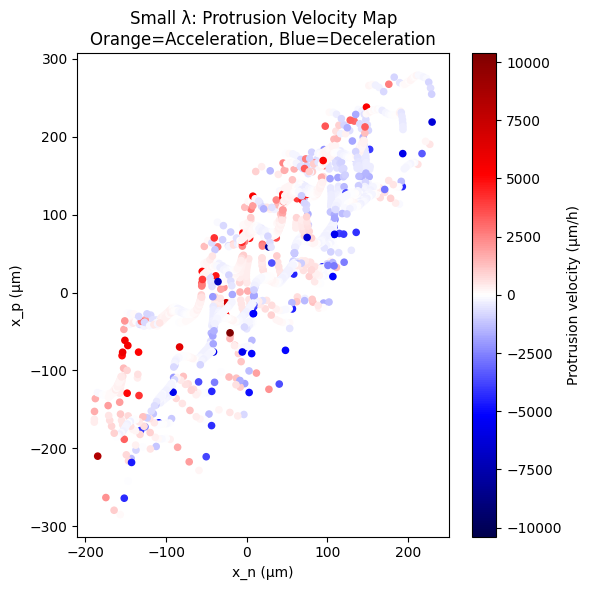

Plotting example trajectory for large λ...


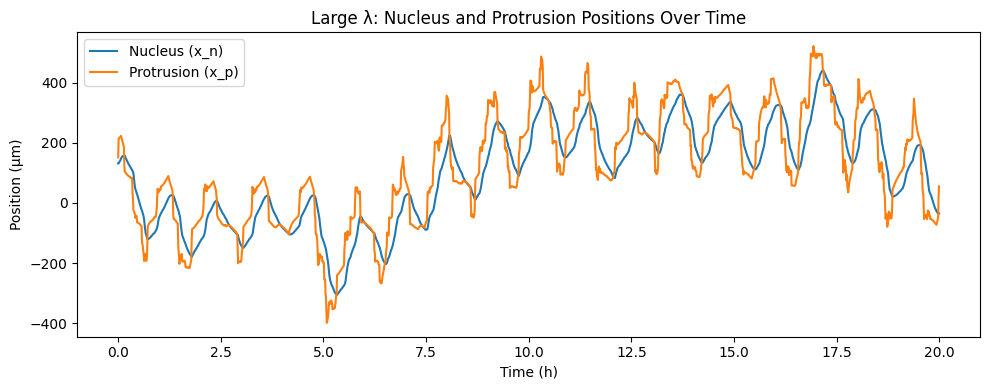

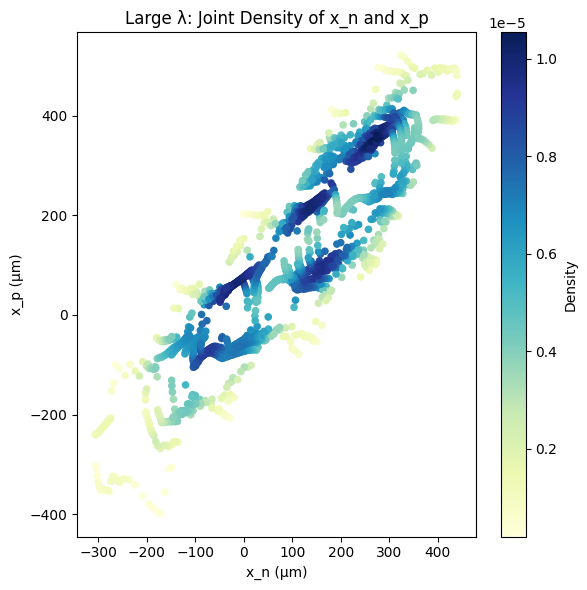

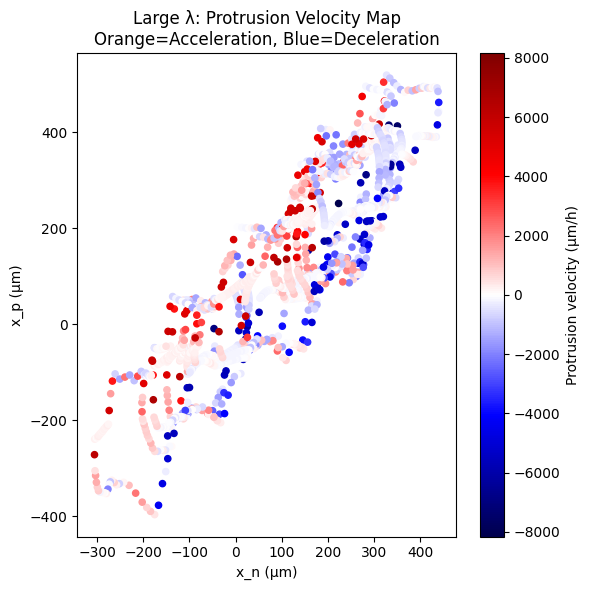

Signal-force relation for Small λ (Nucleus)...


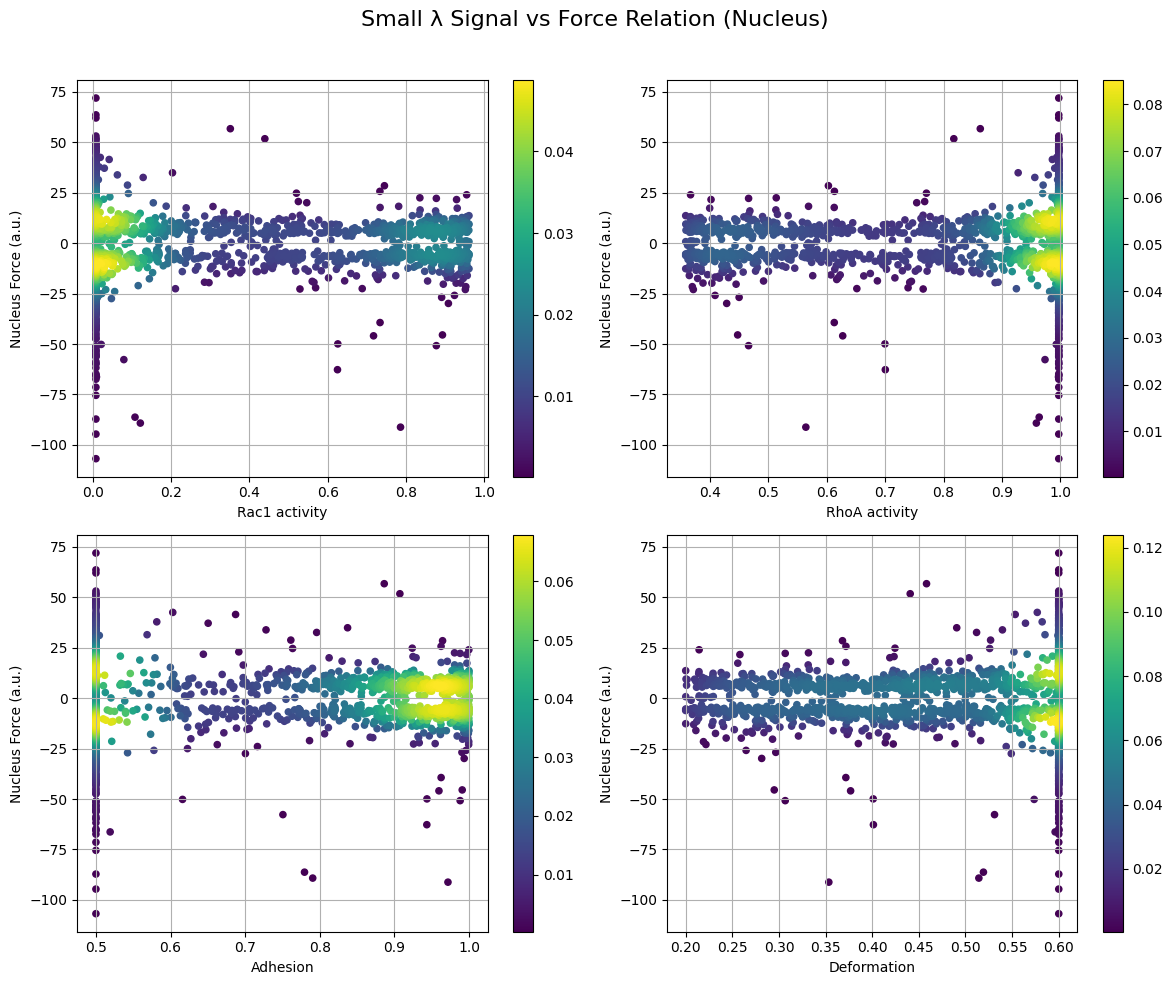

Signal-force relation for Small λ (Protrusion)...


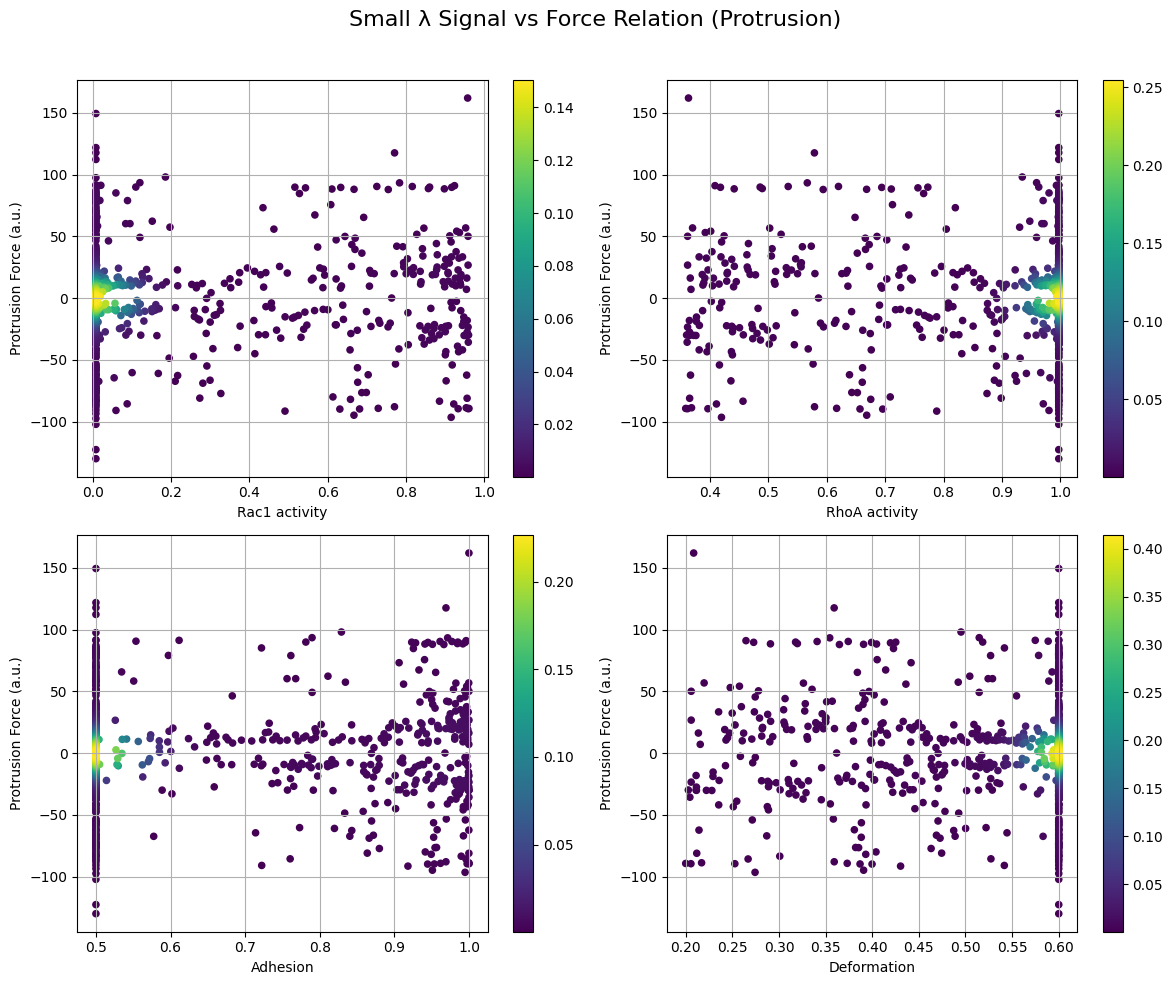

Signal-force relation for Large λ (Nucleus)...


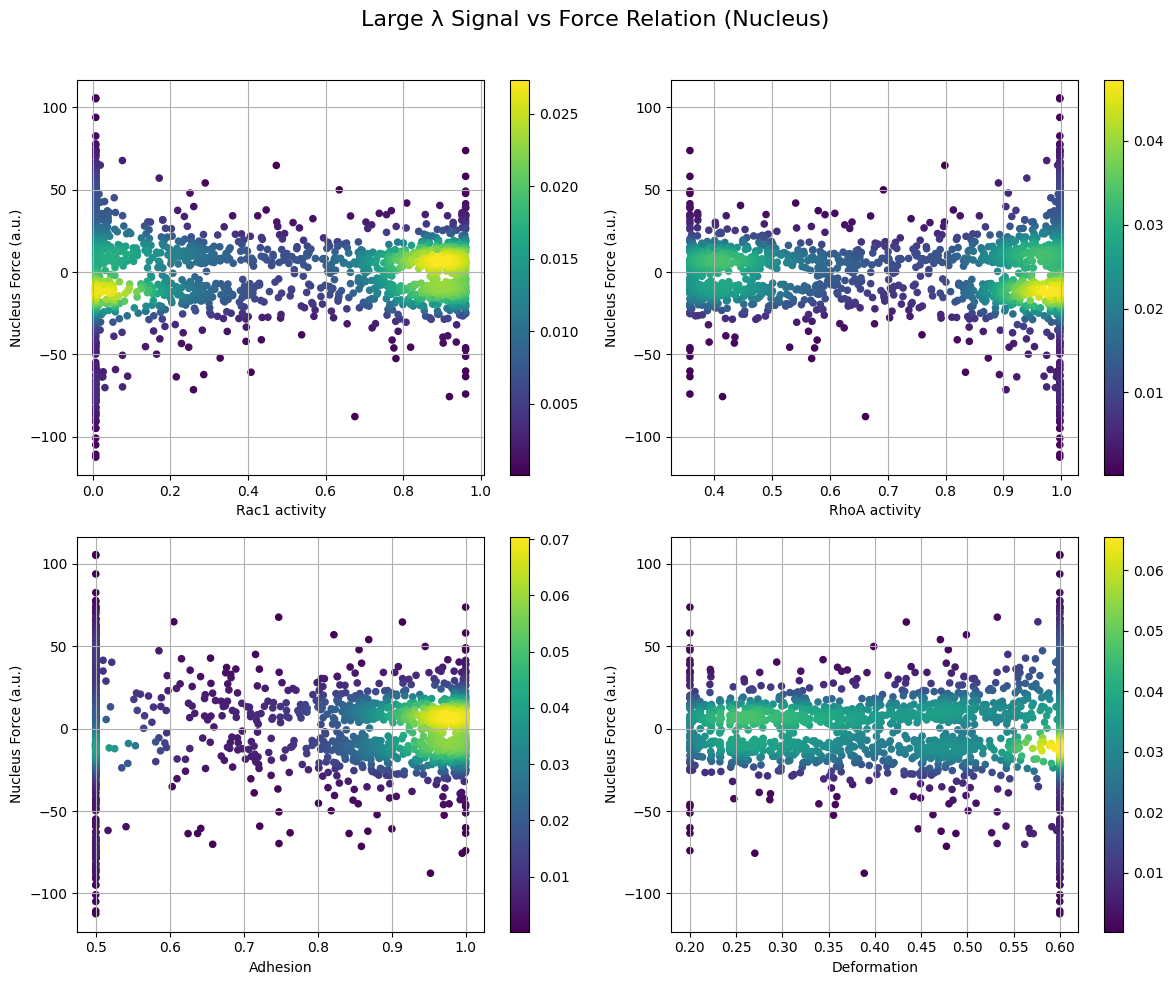

Signal-force relation for Large λ (Protrusion)...


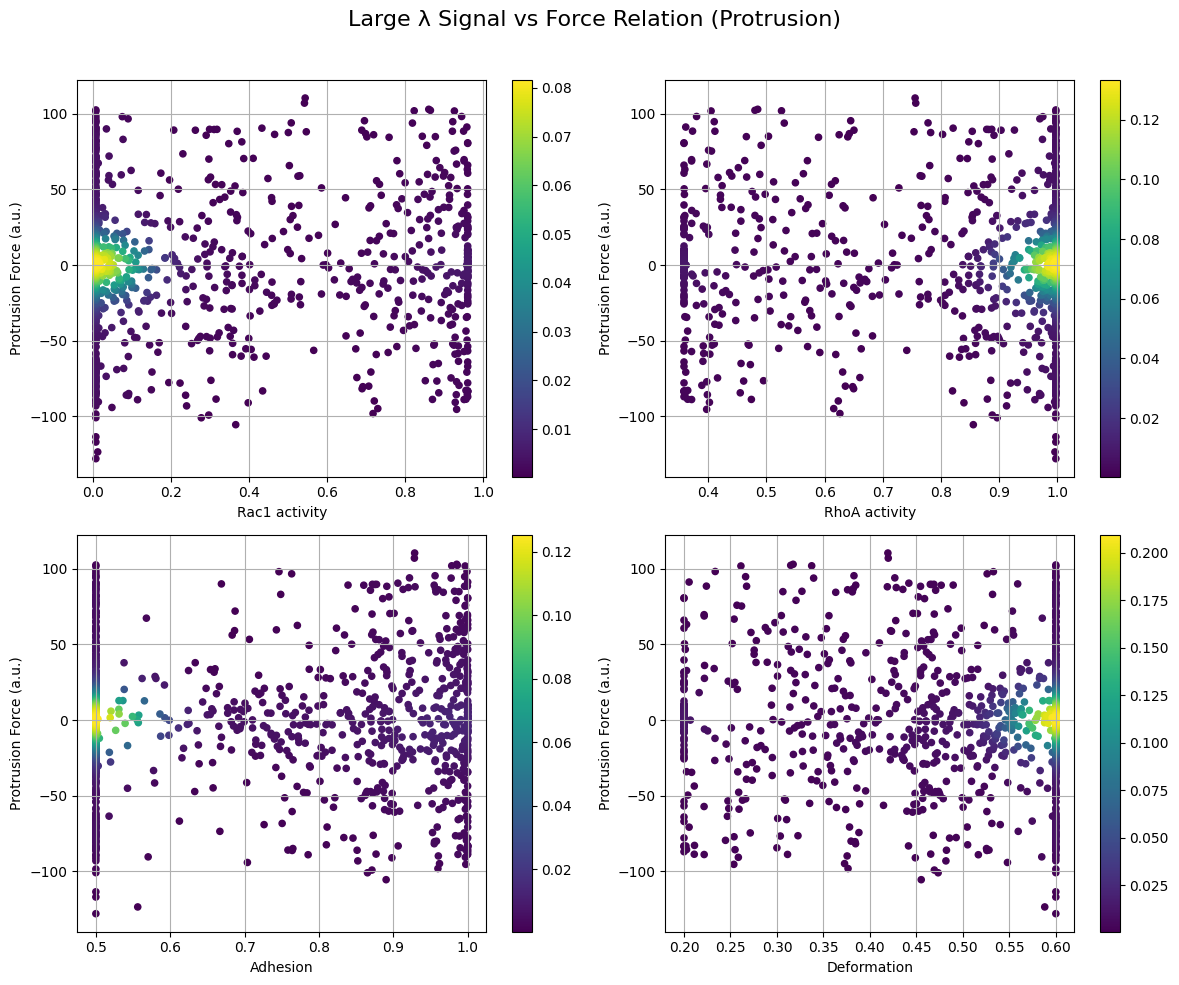

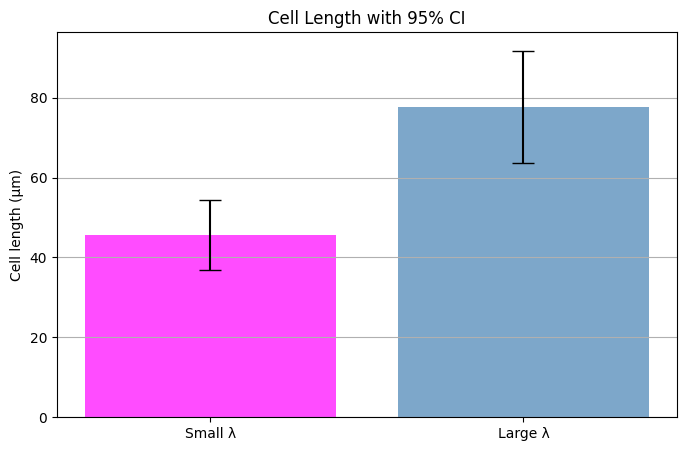

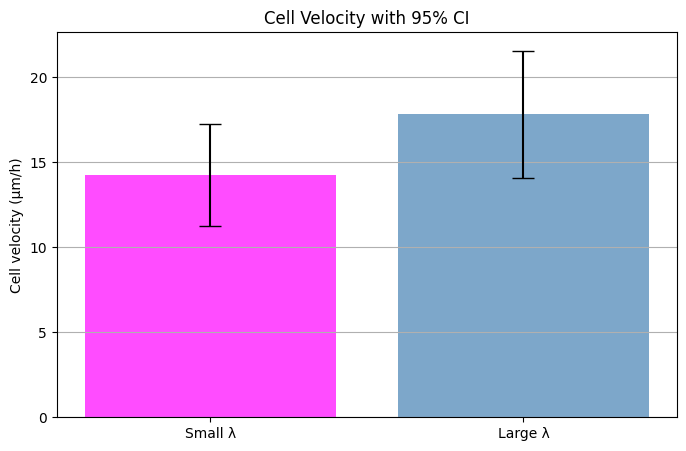

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, gaussian_kde, sem, t
import warnings

# ---------- 参数配置 ----------
PARAMS = {
    'A_small': 100,
    'T_small': 100,
    'A_large': 300,
    'T_large': 300,
    'lamda_small': 0.008,
    'lamda_large': 0.008,
    'a_spring_curv': 1000.0,
    'k0': 0.1,
    'F_protru': 100.0,
    'L0': 20.0,
    'dt': 0.01,
    'n_steps': 2000,
    'noise_scale_factor': 1 / 150,
    'turn_threshold': 0.2,
    'turn_base_prob': 0.1,
    'turn_freeze_steps': 50,
    'confidence_level': 0.95,
}

# ---------- 生物力学模块 ----------
class MolecularMechanism:
    def __init__(self, max_curvature=0.002):
        self.max_curvature = max_curvature

    def rac1(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 1.0 / (1 + np.exp(8 * (norm_k - 0.4)))

    def rhoA(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 0.3 + 0.7 / (1 + np.exp(-8 * (norm_k - 0.3)))

    def adhesion(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 1.0 - 0.5 * (norm_k ** 2)

    def deformation(self, curvature):
        norm_k = np.clip(abs(curvature) / self.max_curvature, 0, 1)
        return 0.2 + 0.8 * norm_k / (1 + norm_k)

    def velocity_modifier(self, rac1, rhoA, adhesion, deformation):
        vmod = 0.7 * rac1 + 0.1 * adhesion - 0.6 * rhoA - 0.2 * deformation
        return np.clip(vmod, 0.2, 1.8)

    def state(self, curvature):
        r = self.rac1(curvature)
        rh = self.rhoA(curvature)
        ad = self.adhesion(curvature)
        de = self.deformation(curvature)
        vm = self.velocity_modifier(r, rh, ad, de)
        return {'rac1': r, 'rhoA': rh, 'adhesion': ad, 'deformation': de, 'velocity_modifier': vm}

# ---------- 细胞迁移模型 ----------
class CellMigrationModel:
    def __init__(self, A, T, lamda=0.01,
                 a_spring_curv=1000.0, F_protru=120.0,
                 L0=10.0, dt=0.001, n_steps=8000,
                 noise_amp=None,
                 mol=None):
        self.A = A
        self.T = T
        self.lamda = lamda
        self.a_spring_curv = a_spring_curv
        self.F_protru = F_protru
        self.L0 = L0
        self.dt = dt
        self.n_steps = n_steps
        self.noise_amp = noise_amp if noise_amp is not None else T * PARAMS['noise_scale_factor']

        self.mol = mol if mol is not None else MolecularMechanism()

        self.xn = np.zeros(n_steps)
        self.xp = np.zeros(n_steps)

        self.xn[0] = np.random.uniform(0, T)
        self.xp[0] = self.xn[0] + self.L0

        self.curvature_nuc_list = np.zeros(n_steps)
        self.curvature_prot_list = np.zeros(n_steps)
        self.signals_nuc_list = [None] * n_steps
        self.signals_prot_list = [None] * n_steps
        self.force_nuc_list = np.zeros(n_steps)
        self.force_prot_list = np.zeros(n_steps)

        self.prot_direction = 1
        self.turning = False
        self.turn_freeze_steps = PARAMS['turn_freeze_steps']
        self.turn_freeze_counter = 0
        self.turn_threshold = PARAMS['turn_threshold']
        self.turn_base_prob = PARAMS['turn_base_prob']

    def curvature(self, x):
        h = 1e-6
        y1 = self.A * np.sin(2 * np.pi * (x - h) / self.T)
        y2 = self.A * np.sin(2 * np.pi * (x + h) / self.T)
        y0 = self.A * np.sin(2 * np.pi * x / self.T)
        dy = (y2 - y1) / (2 * h)
        dyy = (y2 - 2 * y0 + y1) / (h * h)
        k = dyy / (1 + dy**2)**1.5
        return np.clip(k, -0.005, 0.005)

    def simulate(self, verbose=False):
        noise_std = self.noise_amp * np.sqrt(self.dt)
        k0 = PARAMS['k0']

        for i in range(1, self.n_steps):
            L = self.xp[i - 1] - self.xn[i - 1]
            k_nuc = self.curvature(self.xn[i - 1])
            k_prot = self.curvature(self.xp[i - 1])

            ms_nuc = self.mol.state(k_nuc)
            ms_prot = self.mol.state(k_prot)

            F_spring_n = k0 * (1 + self.a_spring_curv * abs(k_nuc)) * (L - self.L0)
            F_spring_p = -F_spring_n

            if self.turning:
                self.turn_freeze_counter -= 1
                if self.turn_freeze_counter <= 0:
                    self.turning = False
            else:
                delta_rac_rho = ms_prot['rac1'] - ms_prot['rhoA']
                adhesion_factor = 1.0 - ms_prot['adhesion']
                turn_prob_dynamic = self.turn_base_prob + adhesion_factor * 0.2
                if delta_rac_rho < self.turn_threshold:
                    if np.random.uniform() < turn_prob_dynamic:
                        self.prot_direction *= -1
                        self.turning = True
                        self.turn_freeze_counter = self.turn_freeze_steps
                        if verbose:
                            print(f"Turn triggered at step {i}, delta_rac_rho={delta_rac_rho:.3f}, adhesion={ms_prot['adhesion']:.3f}")

            F_protrusion = self.prot_direction * self.F_protru * (ms_prot['rac1'] * 0.7 + ms_prot['adhesion'] * 0.3)

            lamda_nuc = self.lamda * (1 + ms_nuc['deformation'])

            F_total_n = F_spring_n
            F_total_p = F_spring_p + F_protrusion

            v_n = (F_total_n / lamda_nuc) * ms_nuc['velocity_modifier']
            v_p = (F_total_p / self.lamda) * ms_prot['velocity_modifier']

            noise_n = np.random.normal(0, noise_std)
            noise_p = np.random.normal(0, noise_std)

            self.xn[i] = self.xn[i - 1] + v_n * self.dt + noise_n
            self.xp[i] = self.xp[i - 1] + v_p * self.dt + noise_p

            self.curvature_nuc_list[i] = k_nuc
            self.curvature_prot_list[i] = k_prot
            self.signals_nuc_list[i] = ms_nuc.copy()
            self.signals_prot_list[i] = ms_prot.copy()
            self.force_nuc_list[i] = F_total_n
            self.force_prot_list[i] = F_total_p

    def get_cell_length(self):
        return self.xp[-1] - self.xn[-1]

    def get_velocity(self):
        velocities = np.diff(self.xn) / self.dt
        start_idx = int(len(velocities) * 0.4)
        return np.mean(velocities[start_idx:])

# ---------- 统计与绘图 ----------
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    se = sem(a)
    h = se * t.ppf((1 + confidence) / 2., n-1)
    return m, m - h, m + h

def plot_mean_with_ci(data_small, data_large, ylabel='Value', title='Comparison',
                      groups=['Small λ', 'Large λ']):
    vals_small = np.abs(np.array(data_small))  # 取绝对值
    vals_large = np.abs(np.array(data_large))  # 取绝对值
    mean_s, lower_s, upper_s = mean_confidence_interval(vals_small)
    mean_l, lower_l, upper_l = mean_confidence_interval(vals_large)
    means = [mean_s, mean_l]
    lowers = [mean_s - lower_s, mean_l - lower_l]
    uppers = [upper_s - mean_s, upper_l - mean_l]
    x_pos = np.arange(len(groups))

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x_pos, means, yerr=[lowers, uppers], capsize=8,
           color=['magenta', 'steelblue'], alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(groups)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y')
    plt.show()

def plot_results(data_small, data_large):
    groups = ['Small λ', 'Large λ']
    colors = ['magenta', 'steelblue']

    lengths_small = np.abs(data_small['lengths'])
    lengths_large = np.abs(data_large['lengths'])
    velocities_small = np.abs(data_small['velocities'])  # 取绝对值
    velocities_large = np.abs(data_large['velocities'])  # 取绝对值

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    ax = axs[0]
    means = [np.mean(lengths_small), np.mean(lengths_large)]
    data_points = [lengths_small, lengths_large]
    for i, (mean, vals, color) in enumerate(zip(means, data_points, colors)):
        ax.bar(i, mean, color=color, alpha=0.7)
        ax.scatter(np.ones_like(vals)*i + np.random.uniform(-0.1, 0.1, len(vals)), vals, color='k', alpha=0.6)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(groups)
    ax.set_ylabel('Cell length (μm)')
    ax.set_title('Cell length comparison')

    ax = axs[1]
    means = [np.mean(velocities_small), np.mean(velocities_large)]
    data_points = [velocities_small, velocities_large]
    for i, (mean, vals, color) in enumerate(zip(means, data_points, colors)):
        ax.bar(i, mean, color=color, alpha=0.7)
        ax.scatter(np.ones_like(vals)*i + np.random.uniform(-0.1, 0.1, len(vals)), vals, color='k', alpha=0.6)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(groups)
    ax.set_ylabel('Cell speed (μm/h)')  # 改成speed表达速率含义
    ax.set_title('Cell speed comparison')

    plt.tight_layout()
    plt.show()

    print("Length significance (small vs large λ):", ttest_ind(lengths_small, lengths_large).pvalue)
    print("Speed significance (small vs large λ):", ttest_ind(velocities_small, velocities_large).pvalue)

def plot_trajectory_density_velocity(xn, xp, dt, title_prefix=''):
    time = np.arange(len(xn)) * dt
    plt.figure(figsize=(10, 4))
    plt.plot(time, xn, label='Nucleus (x_n)')
    plt.plot(time, xp, label='Protrusion (x_p)')
    plt.xlabel('Time (h)')
    plt.ylabel('Position (μm)')
    plt.title(f'{title_prefix}Nucleus and Protrusion Positions Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

    xy = np.vstack([xn, xp])
    kde = gaussian_kde(xy)(xy)

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(xn, xp, c=kde, s=20, cmap='YlGnBu')
    plt.colorbar(sc, label='Density')
    plt.xlabel('x_n (μm)')
    plt.ylabel('x_p (μm)')
    plt.title(f'{title_prefix}Joint Density of x_n and x_p')
    plt.tight_layout()
    plt.show()

    v_p = np.diff(xp) / dt
    xn_mid = (xn[:-1] + xn[1:]) / 2
    xp_mid = (xp[:-1] + xp[1:]) / 2

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(xn_mid, xp_mid, c=v_p, cmap='seismic', s=20,
                          vmin=-max(abs(v_p)), vmax=max(abs(v_p)))
    plt.colorbar(scatter, label='Protrusion velocity (μm/h)')
    plt.xlabel('x_n (μm)')
    plt.ylabel('x_p (μm)')
    plt.title(f'{title_prefix}Protrusion Velocity Map\nOrange=Acceleration, Blue=Deceleration')
    plt.tight_layout()
    plt.show()

def plot_signal_force_relation(signals_list, forces_list, title_prefix='', part_name=''):
    # 过滤None，保持信号和力长度一致
    signals_list = [s for s in signals_list if s is not None]
    if len(forces_list) < len(signals_list):
        forces_list = forces_list[-len(signals_list):]
    else:
        forces_list = forces_list[:len(signals_list)]

    if len(signals_list) < 10:
        print(f"Too few data points ({len(signals_list)}) for KDE plot of {part_name}, skipping.")
        return

    rac1_vals = np.array([s['rac1'] for s in signals_list])
    rhoA_vals = np.array([s['rhoA'] for s in signals_list])
    adhesion_vals = np.array([s['adhesion'] for s in signals_list])
    deformation_vals = np.array([s['deformation'] for s in signals_list])
    forces = np.array(forces_list)

    valid_idx = (~np.isnan(forces)) & (~np.isnan(rac1_vals)) & (~np.isnan(rhoA_vals)) & \
                (~np.isnan(adhesion_vals)) & (~np.isnan(deformation_vals))
    if np.sum(valid_idx) < 10:
        print(f"Too few valid data points after NaN filtering for {part_name}, skipping.")
        return

    rac1_vals = rac1_vals[valid_idx]
    rhoA_vals = rhoA_vals[valid_idx]
    adhesion_vals = adhesion_vals[valid_idx]
    deformation_vals = deformation_vals[valid_idx]
    forces = forces[valid_idx]

    warnings.filterwarnings('ignore')

    def scatter_kde(x, y, ax, xlabel, ylabel):
        xy = np.vstack([x, y])
        try:
            z = gaussian_kde(xy)(xy)
        except Exception as e:
            print(f"KDE failed for {xlabel} vs {ylabel}: {e}")
            z = np.ones_like(x)  # Fallback: uniform color
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        sc = ax.scatter(x, y, c=z, s=20, cmap='viridis')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        fig.colorbar(sc, ax=ax)
        ax.grid(True)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()

    scatter_kde(rac1_vals, forces, axs[0], 'Rac1 activity', f'{part_name} Force (a.u.)')
    scatter_kde(rhoA_vals, forces, axs[1], 'RhoA activity', f'{part_name} Force (a.u.)')
    scatter_kde(adhesion_vals, forces, axs[2], 'Adhesion', f'{part_name} Force (a.u.)')
    scatter_kde(deformation_vals, forces, axs[3], 'Deformation', f'{part_name} Force (a.u.)')

    plt.suptitle(f'{title_prefix} Signal vs Force Relation ({part_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------- 批量模拟 ----------
def batch_run(A, T, lamda, n=50):
    lengths = []
    velocities = []
    all_xn = []
    all_xp = []
    all_signals_nuc = []
    all_forces_nuc = []
    all_signals_prot = []
    all_forces_prot = []

    for i in range(n):
        model = CellMigrationModel(A, T, lamda=lamda,
                                   a_spring_curv=PARAMS['a_spring_curv'],
                                   F_protru=PARAMS['F_protru'],
                                   L0=PARAMS['L0'],
                                   dt=PARAMS['dt'],
                                   n_steps=PARAMS['n_steps'],
                                   noise_amp=T*PARAMS['noise_scale_factor'])
        model.simulate()
        lengths.append(model.get_cell_length())
        velocities.append(model.get_velocity())
        all_xn.append(model.xn.copy())
        all_xp.append(model.xp.copy())
        all_signals_nuc.append(model.signals_nuc_list.copy())
        all_forces_nuc.append(model.force_nuc_list.copy())
        all_signals_prot.append(model.signals_prot_list.copy())
        all_forces_prot.append(model.force_prot_list.copy())

    data = {'lengths': lengths, 'velocities': velocities}
    return data, all_xn, all_xp, all_signals_nuc, all_forces_nuc, all_signals_prot, all_forces_prot

# ---------- 主程序 ----------
if __name__ == "__main__":
    print("Running small λ simulations...")
    data_small, all_xn_small, all_xp_small, sig_nuc_small, f_nuc_small, sig_prot_small, f_prot_small = \
        batch_run(PARAMS['A_small'], PARAMS['T_small'], PARAMS['lamda_small'], n=50)

    print("Running large λ simulations...")
    data_large, all_xn_large, all_xp_large, sig_nuc_large, f_nuc_large, sig_prot_large, f_prot_large = \
        batch_run(PARAMS['A_large'], PARAMS['T_large'], PARAMS['lamda_large'], n=50)

    plot_results(data_small, data_large)

    print("Plotting example trajectory for small λ...")
    plot_trajectory_density_velocity(all_xn_small[0], all_xp_small[0], PARAMS['dt'], title_prefix='Small λ: ')

    print("Plotting example trajectory for large λ...")
    plot_trajectory_density_velocity(all_xn_large[0], all_xp_large[0], PARAMS['dt'], title_prefix='Large λ: ')

    print("Signal-force relation for Small λ (Nucleus)...")
    plot_signal_force_relation(sig_nuc_small[0], f_nuc_small[0], title_prefix='Small λ', part_name='Nucleus')

    print("Signal-force relation for Small λ (Protrusion)...")
    plot_signal_force_relation(sig_prot_small[0], f_prot_small[0], title_prefix='Small λ', part_name='Protrusion')

    print("Signal-force relation for Large λ (Nucleus)...")
    plot_signal_force_relation(sig_nuc_large[0], f_nuc_large[0], title_prefix='Large λ', part_name='Nucleus')

    print("Signal-force relation for Large λ (Protrusion)...")
    plot_signal_force_relation(sig_prot_large[0], f_prot_large[0], title_prefix='Large λ', part_name='Protrusion')

    plot_mean_with_ci(data_small['lengths'], data_large['lengths'], ylabel='Cell length (μm)', title='Cell Length with 95% CI')
    plot_mean_with_ci(data_small['velocities'], data_large['velocities'], ylabel='Cell velocity (μm/h)', title='Cell Velocity with 95% CI')
